In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from os import listdir

from scipy.signal import resample
import librosa as lb

Mounted at /content/drive


In [2]:
directory= "/content/drive/My Drive/Respiratory_Sound_Database/audio_and_txt_files/"
def ls(ruta = '.'):
    return listdir(ruta)
archivos=ls(directory)#lista de todos los archivos en la carpeta
archivos=[archivos[i][0:-4] for i in range(len(archivos)) if '.txt' in archivos[i]] #solo los nombres

In [17]:
diagnosis=pd.read_csv("/content/drive/My Drive/Respiratory_Sound_Database/patient_diagnosis.csv",header=None,names=['paciente','diagnostico'])
d=pd.get_dummies(diagnosis, columns = ['diagnostico'],sparse=False)

In [19]:
matriz1={'File':[],
        'Patient':[],
         'Equipment':[],
         'mc/sc':[]
}
for archivo in archivos:
  matriz1['File'].append(archivo)
  matriz1['Patient'].append(int(archivo[0:3]))
  matriz1['Equipment'].append(archivo[14:])
  matriz1['mc/sc'].append(archivo[11:13])
df1=pd.DataFrame(matriz1,index=None)

diagnosticos=[]
for i in df1['Patient']:
  diagnosticos.append(diagnosis['diagnostico'][diagnosis['paciente']==i].values[0])

df1['Diagnosis']=diagnosticos

In [20]:
df1

,File,Patient,Equipment,mc/sc,Diagnosis
0,185_1b1_Pl_sc_Litt3200,185,Litt3200,sc,COPD
1,185_1b1_Lr_sc_Litt3200,185,Litt3200,sc,COPD
2,185_1b1_Pr_sc_Litt3200,185,Litt3200,sc,COPD
3,186_2b2_Lr_mc_AKGC417L,186,AKGC417L,mc,COPD
4,186_2b2_Al_mc_AKGC417L,186,AKGC417L,mc,COPD
...,...,...,...,...,...
915,183_1b1_Tc_sc_Meditron,183,Meditron,sc,Healthy
916,184_1b1_Ar_sc_Meditron,184,Meditron,sc,Healthy
917,185_1b1_Al_sc_Litt3200,185,Litt3200,sc,COPD
918,185_1b1_Ar_sc_Litt3200,185,Litt3200,sc,COPD


In [4]:
from IPython.display import HTML, display
import time
import IPython

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 80%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Extracción de Características

Luego de hacer una exploracon inicial y entrenando varios modelos se opto por solo usar características basadas en las MFCC.

Cada archivo de audio viene acopañado de anotaciones de inicio, fin de ciclo y presencia de crujidos y silibancias con el mismo nombre en fotmato .txt. 

$
 \begin{pmatrix}
  ti & tf &  & c & w\\
  1 & 2 &  & 0 & 1\\ 
  2.2 & 3 &  & 1 & 0\\
  3.5 & 4 &  & 1 & 1\\
  4.1 & 5 &  & 0 & 0\\
 \end{pmatrix}$

In [5]:
_, rate = lb.load(directory+archivos[archivos.index('185_1b1_Pl_sc_Litt3200')]+'.wav',sr=None)
print(rate)

4000


In [6]:
def respiratory_cycle(s,resampl=None):
  '''
  Esta función extrae los ciclos respiratorios.
  Parametros
    s: nombre del archivo a leer (sin .wav)
    resampl: frecuencia a la que se quiere convertir
  Devuelve 
    data: conjunto de datos con los ciclos
    rate: frecuencia de muestreo de salida
    df_annot: conjunto de anotaciones
  '''
  path=directory + s +'.wav'
  x, rate = lb.load(path,sr=resampl)

  path=directory + s +'.txt'
  df_annot = pd.read_csv(path,sep="\t")
  df_annot=df_annot.values
  
  data=[]

  #separar los ciclos
  for i in range(np.shape(df_annot)[0]):
    y=x[int(df_annot[i,0]*rate):int(df_annot[i,1]*rate)]
    y=y/np.max(np.abs(y))#normaliza

    data.append(y)
  return data,rate,df_annot

Archivo:  189_1b2_Lr_mc_LittC2SE
[[ 4.764  9.621  1.     0.   ]
 [ 9.621 14.921  0.     0.   ]
 [14.921 19.579  0.     0.   ]
 [19.579 19.936  0.     0.   ]] fs salida:  4000


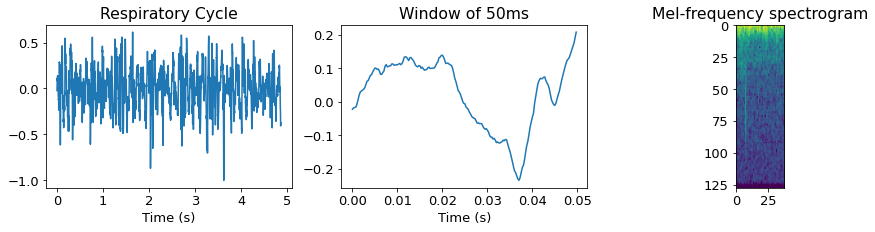

In [7]:
f=archivos[33]
data,rate,df_annot=respiratory_cycle(f,resampl=4000)

print('Archivo: ',f)
print(df_annot,'fs salida: ',rate)

plt.rcParams.update({'font.size': 13})

fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,3))
s=data[0]
t=np.linspace(0,np.shape(s)[0]/rate,np.shape(s)[0])
ax[0].plot(t,s)
ax[0].set_title('Respiratory Cycle')
ax[0].set_xlabel('Time (s)')

t=np.linspace(0,np.shape(s)[0]/rate,np.shape(s)[0])
ax[1].plot(t[0:int(rate*0.05)],s[0:int(rate*0.05)])
ax[1].set_title('Window of 50ms')
ax[1].set_xlabel('Time (s)')

S=lb.feature.melspectrogram(y=s, sr=4000,n_fft=int(4000*0.05))
S_dB = lb.power_to_db(S, ref=np.max)
# img = lb.display.specshow(S_dB, x_axis='time',
#                          y_axis='mel', sr=4000,
#                          fmax=8000, ax=ax[2])
# fig.colorbar(img, ax=ax[2], format='%+2.0f dB')

ax[2].set(title='Mel-frequency spectrogram')
ax[2].imshow(S_dB)
plt.savefig('signal.png',format='png',)

In [8]:
def cycle_characteristics(signal,rate,window):
  n_fft=int(rate*window) 
  hop_length=int(rate*window/2)
  S_mag, phase = lb.magphase(lb.stft(y=signal,n_fft=n_fft,hop_length=hop_length))

  mfccs=lb.feature.mfcc(y=signal, sr=rate, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
  zcr  =lb.feature.zero_crossing_rate(y=signal, frame_length=n_fft, hop_length=hop_length)#zero crossing rate
  rms  =lb.feature.rms(S=S_mag,frame_length=n_fft, hop_length=hop_length)#RMS

  sr90 =lb.feature.spectral_rolloff(y=signal, sr=rate, S=S_mag, n_fft=n_fft, hop_length=hop_length,roll_percent=0.9)
  sr10 =lb.feature.spectral_rolloff(y=signal, sr=rate, S=S_mag, n_fft=n_fft, hop_length=hop_length,roll_percent=0.1)#rolloff
  sc   =lb.feature.spectral_centroid(y=signal, S=S_mag, sr=rate, n_fft=n_fft, hop_length=hop_length)#spectral centroid

  c = np.concatenate( (mfccs,zcr,rms,sr90,sr10,sc),axis = 0 )
  c = np.concatenate( (c.mean(axis=1),c.std(axis=1)) )
  return c

In [9]:
cycle_characteristics(s,4000,0.05).shape

(36,)

In [25]:
def respiratory_cycle(s,resampl=None):
  '''
  Esta función extrae los ciclos respiratorios.
  Parametros
    s: nombre del archivo a leer (sin .wav)
    resampl: frecuencia a la que se quiere convertir
  Devuelve 
    data: conjunto de datos con los ciclos
    rate: frecuencia de muestreo de salida
    df_annot: conjunto de anotaciones
  '''
  path=directory + s +'.wav'
  x, rate = lb.load(path,sr=resampl)

  path=directory + s +'.txt'
  df_annot = pd.read_csv(path,sep="\t",names=["ti","tf","c","w"])
  df_annot=df_annot.values
  
  data=[]

  #separar los ciclos
  for i in range(np.shape(df_annot)[0]):
    y=x[int(df_annot[i,0]*rate):int(df_annot[i,1]*rate)]
    y=y/np.max(np.abs(y))#normaliza

    data.append(y)
  return data,rate,df_annot

In [26]:
w=0.05#ventana para las caracteristicas en segundos
num_archivos=len(archivos)
c = []
targets = []
indexs=[]
verificar=0
out = display(progress(0, 100), display_id=True)
for cont in range(num_archivos):#recorrer la lista de archivos
  
  data,rate,df_annot=respiratory_cycle(df1["File"][cont],resampl=4000)

  for k in range(np.shape(df_annot)[0]):
    verificar+=1
    if (df_annot[k,1] - df_annot[k,0]) > 1.0:
      c.append(cycle_characteristics(data[k],rate,w))
      targets.append([df_annot[k,2],df_annot[k,3]])
      indexs.append(df1["File"][cont])
  out.update(progress(cont, num_archivos))

In [27]:
verificar

6898

In [28]:
carac=np.array(c,dtype=np.float64)
targets=np.array(targets,dtype=np.float16)

In [29]:
carac.shape

(6596, 36)

In [31]:
texto='''mfcc1 m, mfcc2 m, mfcc3 m, mfcc4 m, mfcc5 m, mfcc6 m, mfcc7 m, mfcc8 m, mfcc9 m, mfcc10 m, mfcc11 m, mfcc12 m, mfcc13 m, zcr m, rms m, sr90 m, sr10 m, sc m, mfcc1 s, mfcc2 s, mfcc3 s, mfcc4 s, mfcc5 s, mfcc6 s, mfcc7 s, mfcc8 s, mfcc9 s, mfcc10 s, mfcc11 s, mfcc12 s, mfcc13 s, zcr s, rms s, sr90 s, sr10 s, sc s, crackles,wheezes'''
datos=pd.DataFrame(np.concatenate((carac,targets),axis=1),columns=texto.split(','),index=indexs)
datos.to_csv('/content/drive/MyDrive/Respiratory Sounds Final/Resultados/Caracteristicas_50ms.csv')

#Exploracion de las características

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as kr
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sys

In [33]:
def plot_model(model_details):

    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_details.history['binary_accuracy'])+1),model_details.history['binary_accuracy'])
    axs[0].plot(range(1,len(model_details.history['val_binary_accuracy'])+1),model_details.history['val_binary_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_details.history['binary_accuracy'])+1),len(model_details.history['binary_accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    # Show the plot
    plt.show()

In [34]:
path='/content/drive/MyDrive/Respiratory Sounds Final/Resultados/Caracteristicas_50ms.csv'
f=pd.read_csv(path,index_col=0)
f

,mfcc1 m,mfcc2 m,mfcc3 m,mfcc4 m,mfcc5 m,mfcc6 m,mfcc7 m,mfcc8 m,mfcc9 m,mfcc10 m,mfcc11 m,mfcc12 m,mfcc13 m,zcr m,rms m,sr90 m,sr10 m,sc m,mfcc1 s,mfcc2 s,mfcc3 s,mfcc4 s,mfcc5 s,mfcc6 s,mfcc7 s,mfcc8 s,mfcc9 s,mfcc10 s,mfcc11 s,mfcc12 s,mfcc13 s,zcr s,rms s,sr90 s,sr10 s,sc s,crackles,wheezes
185_1b1_Pl_sc_Litt3200,-589.591029,131.389230,63.493940,26.760284,22.557836,33.508998,38.848222,31.144898,13.578782,0.284023,1.748843,7.601834,8.090828,0.024444,0.063280,174.444444,10.000000,78.214859,64.987357,52.572147,12.756716,20.787685,17.440373,11.363580,8.541744,6.256826,8.689657,12.924291,9.339297,6.827550,6.735329,0.017968,0.054006,149.835301,14.272481,46.387191,0.0,0.0
185_1b1_Pl_sc_Litt3200,-581.044548,121.635670,61.670678,28.192341,24.879534,33.596947,37.885314,29.653484,13.997268,2.680912,1.866408,6.642613,8.364908,0.021780,0.071204,150.169492,5.084746,66.240480,58.414507,50.611229,9.602336,18.742106,15.465624,11.142301,8.371553,7.881634,9.266318,12.593085,10.558823,7.829590,6.946724,0.021585,0.068310,129.477326,10.146867,43.912211,0.0,0.0
185_1b1_Pl_sc_Litt3200,-598.217053,109.999709,59.749163,28.113759,23.889319,34.740860,39.931550,30.904566,14.771626,4.019007,4.068982,8.681248,8.980083,0.019531,0.046053,160.000000,5.000000,69.952327,50.900070,44.967981,9.996845,17.859085,18.187130,10.805468,7.194531,7.701547,7.865830,8.923142,9.451938,6.802540,5.671779,0.013072,0.056099,135.738720,8.660254,35.263267,0.0,0.0
185_1b1_Pl_sc_Litt3200,-570.075751,120.712097,62.016228,26.135826,20.941721,31.641492,38.254581,29.938638,12.702541,1.376405,1.975626,7.439226,8.924485,0.022672,0.066012,178.965517,7.586207,75.248639,55.476769,49.566216,11.765426,18.459689,17.274548,10.611706,7.082321,6.409925,9.666563,12.395002,9.889809,7.378797,6.864251,0.018458,0.067441,137.586207,13.301587,41.610102,0.0,0.0
185_1b1_Pl_sc_Litt3200,-598.682280,114.319651,58.331105,25.858037,22.480481,30.364347,33.848522,27.763018,14.371029,4.092378,3.213012,6.575028,7.073993,0.023033,0.044521,188.196721,4.262295,77.407863,59.899636,52.910176,9.119042,21.919086,18.562633,11.797893,8.928351,7.399693,9.689796,10.874190,8.737941,5.598956,5.619356,0.020067,0.061183,150.904467,8.955082,47.782499,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185_1b1_Ll_sc_Litt3200,-615.676149,129.935606,66.997785,33.309565,33.560314,41.868874,39.555304,26.159190,11.646169,4.368811,4.352701,6.739777,6.926846,0.016759,0.068794,110.740741,2.962963,55.546563,53.841475,42.674206,16.115701,18.065548,11.455504,8.921974,8.245947,8.965014,8.657543,8.000651,7.535005,7.478017,6.252233,0.013850,0.059789,73.807855,7.104936,24.867315,0.0,0.0
185_1b1_Ll_sc_Litt3200,-595.900676,116.508813,62.158897,35.053003,35.418924,41.711288,36.347884,22.169363,8.693626,2.541597,2.858625,5.129558,6.648000,0.016667,0.059115,142.380952,3.809524,63.206753,56.519684,41.235097,18.824549,19.782177,13.206860,10.472161,8.153567,8.527776,8.857747,7.383875,6.823079,6.806487,6.111595,0.009008,0.062678,115.651561,7.853535,31.511473,0.0,0.0
185_1b1_Ll_sc_Litt3200,-624.835059,127.407752,68.645604,34.987925,37.077736,46.450079,40.634284,23.826095,9.465406,4.247881,5.629318,7.300389,6.272999,0.015500,0.064836,104.000000,5.200000,53.160262,36.911217,33.056096,13.132992,16.497856,12.074964,7.954701,8.475441,9.891191,6.959761,6.303467,7.783006,8.272875,7.100766,0.008789,0.046199,62.481997,8.772685,24.624722,0.0,0.0
185_1b1_Ll_sc_Litt3200,-568.810334,139.965197,60.802145,17.928871,23.951878,40.910931,40.457640,24.538794,8.593089,2.305721,3.671059,6.291494,6.558858,0.017522,0.075590,144.695652,3.478261,67.503894,39.866480,34.253420,14.835264,14.605935,11.674186,8.289746,8.308456,7.874533,6.660030,6.462212,5.620584,5.244075,5.775984,0.011691,0.060676,88.870416,7.580694,30.457809,0.0,1.0


In [35]:
f.keys()

Index(['mfcc1 m', ' mfcc2 m', ' mfcc3 m', ' mfcc4 m', ' mfcc5 m', ' mfcc6 m',
       ' mfcc7 m', ' mfcc8 m', ' mfcc9 m', ' mfcc10 m', ' mfcc11 m',
       ' mfcc12 m', ' mfcc13 m', ' zcr m', ' rms m', ' sr90 m', ' sr10 m',
       ' sc m', ' mfcc1 s', ' mfcc2 s', ' mfcc3 s', ' mfcc4 s', ' mfcc5 s',
       ' mfcc6 s', ' mfcc7 s', ' mfcc8 s', ' mfcc9 s', ' mfcc10 s',
       ' mfcc11 s', ' mfcc12 s', ' mfcc13 s', ' zcr s', ' rms s', ' sr90 s',
       ' sr10 s', ' sc s', ' crackles', 'wheezes'],
      dtype='object')

In [36]:
print('Número de muestras con crujidos: ',sum(f[' crackles']),'\nNúmero de muestras con silibancias: ',sum(f['wheezes']),
      '\nNúmero de muestras totales: ',len(f))

Número de muestras con crujidos:  2332.0 
Número de muestras con silibancias:  1361.0 
Número de muestras totales:  6596


In [37]:
np.random.seed(1)
data=f.values
X = data[:,:-3]
Y = data[:,-3:-1] #target para c y w
Y_copd= data[:,-1] #target para epoc
#scaler = StandardScaler()
scaler =MinMaxScaler((-1,1),True)#Nomaliza entre -1 y 1
X=scaler.fit_transform(X)

test_size= int(X.shape[0]*0.20) #20% para prueba
val_size = int(X.shape[0]*0.1) #10% para validacion

d = np.random.choice(np.arange(X.shape[0]) , size=X.shape[0], replace=False)
x_test = X[d[:test_size],:] 
x_val  = X[d[test_size:test_size+val_size],:]
x_train= X[d[test_size+val_size:],:] 

y_test = Y[d[:test_size]] 
y_val  = Y[d[test_size:test_size+val_size]]
y_train= Y[d[test_size+val_size:]] 

y_test_copd = Y_copd[d[:test_size]] 
y_val_copd  = Y_copd[d[test_size:test_size+val_size]]
y_train_copd= Y_copd[d[test_size+val_size:]] 

print('Dimensiones de prueba, validacion, entrenamiento: ',x_test.shape,x_val.shape,x_train.shape)

Dimensiones de prueba, validacion, entrenamiento:  (1319, 35) (659, 35) (4618, 35)


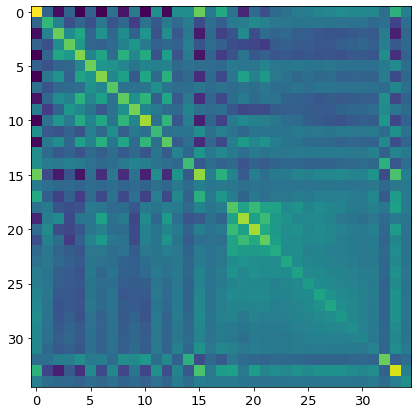

In [38]:
plt.figure(figsize=(7,7))
df=pd.DataFrame(X)
plt.imshow(df.cov())